# Preference Learning

### Mikołaj Nowak 151813  
### Anna Roszkiewicz 151883

---

## Wprowadzenie

Celem projektu jest przeprowadzenie eksperymentów z zakresu *preference learning* z wykorzystaniem różnych modeli klasyfikacyjnych.  
Analiza będzie obejmowała zarówno interpretowalne metody klasyczne, jak i modele oparte na sieciach neuronowych.  

---

## Import niezbędnych bibliotek

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
import shap
import torch
import torch.nn as nn
from typing import Any, Tuple
from functools import partial
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import seaborn as sns

---

## Wybrany zbiór danych

Jako zbiór danych wybraliśmy **Mammographic Mass Dataset**, ponieważ:

- Zawiera **ponad 800 przykładów**,
- Obejmuje **pięć cech wejściowych**, które są monotoniczne,
- Klasa decyzyjna przyjmuje **dwie wartości** (`0` - łagodny guz, `1` - złośliwy guz),
- Jest to najbardziej kompletny i czysty zbiór spośród dostępnych na stronie  
  [Monotone Learning Datasets – Uni Paderborn](https://en.cs.uni-paderborn.de/is/research/research-projects/software/monotone-learning-datasets) pobrany z [Kaggle](https://www.kaggle.com/datasets/overratedgman/mammographic-mass-data-set)

In [2]:
import pandas as pd

df = pd.read_csv('data/mammographic.csv')
df.head()

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
1,5,58,4,5,3,1
2,4,28,1,1,3,0
3,5,57,1,5,3,1
4,5,76,1,4,3,1


In [3]:
X, y = df.drop(columns=['Severity']), df['Severity']
X.describe()

,BI-RADS,Age,Shape,Margin,Density
count,830.000000,830.000000,830.000000,830.000000,830.000000
mean,4.393976,55.781928,2.781928,2.813253,2.915663
std,1.888371,14.671782,1.242361,1.567175,0.350936
min,0.000000,18.000000,1.000000,1.000000,1.000000
25%,4.000000,46.000000,2.000000,1.000000,3.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000


In [4]:
y.value_counts()

Severity
0    427
1    403
Name: count, dtype: int64

In [5]:
df = df[df.iloc[:, 0] != 55]

---

## Opis zbioru danych

Zbiór danych **mammographic** zawiera **830 przykładów**, z czego każdy opisany jest za pomocą **5 kryteriów (cech)** oraz **klasy decyzyjnej** (`Severity`). Dane nie zawierają brakujących wartości (`NULL`). Wszystkie cechy są zapisane jako liczby całkowite reprezentujące skategoryzowane wartości (np. poziomy ryzyka, typy anatomiczne itp.).

#### Kolumny w zbiorze:
- **BI-RADS** – ocena radiologiczna w skali BI-RADS (1–5), im wyższa wartość, tym wyższe podejrzenie złośliwości zmiany.
- **Age** – wiek pacjentki (w latach).
- **Shape** – kształt zmiany:  
  &nbsp;&nbsp;&nbsp;&nbsp;1 = round, 2 = oval, 3 = lobular, 4 = irregular.
- **Margin** – granica zmiany:  
  &nbsp;&nbsp;&nbsp;&nbsp;1 = circumscribed, 2 = microlobulated, 3 = obscured, 4 = ill-defined, 5 = spiculated.
- **Density** – gęstość zmiany w obrazie:  
  &nbsp;&nbsp;&nbsp;&nbsp;1 = high, 2 = iso, 3 = low, 4 = fat-containing.
- **Severity** – klasa decyzyjna:  
  &nbsp;&nbsp;&nbsp;&nbsp;0 = łagodna zmiana, 1 = złośliwa zmiana.

Zbiór danych jest **w miarę zbalansowany** – liczba przykładów w każdej klasie (łagodna vs złośliwa zmiana) jest zbliżona.
Przynajmniej trzy cechy – BI-RADS, Age i Margin – można uznać za monotoniczne względem klasy decyzyjnej (Severity). Pozostałe cechy, takie jak Shape i Density, również wykazują tendencje monotoniczne, co czyni zbiór odpowiednim do dalszej analizy preferencji.


### Przygotowanie danych

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

---

## Regresja Logistyczna

### Trening modelu

In [7]:
model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

### Predykcje

In [8]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

### Metryki

In [9]:
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

Accuracy: 0.8029
F1 score: 0.8057
AUC: 0.8804


### Wizualizacja współczynników regresji (ważność cech)

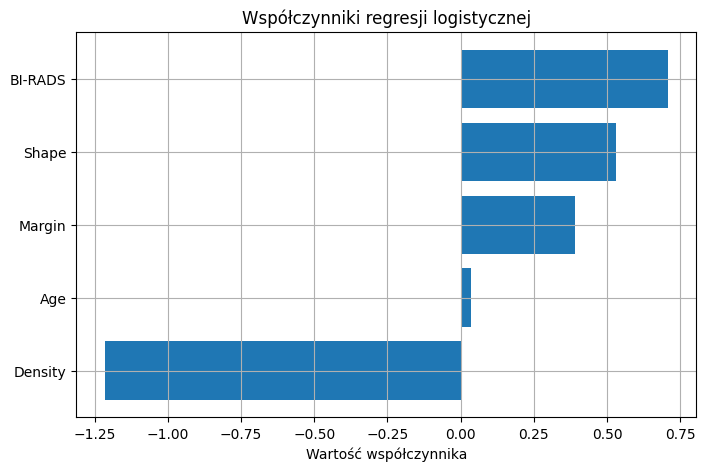

In [10]:
features = X.columns
coef = model.coef_[0]
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coef})
coef_df = coef_df.sort_values(by='Coefficient')

plt.figure(figsize=(8, 5))
plt.barh(coef_df['Feature'], coef_df['Coefficient'])
plt.title('Współczynniki regresji logistycznej')
plt.xlabel('Wartość współczynnika')
plt.grid(True)
plt.show()

### Interpretacja wizualizacji

- **BI-RADS** ma największy pozytywny wpływ na decyzję modelu — im wyższa wartość tej cechy, tym większe prawdopodobieństwo klasy 1.
- **Shape** i **Margin** również pozytywnie wpływają na klasyfikację do klasy 1, choć w mniejszym stopniu.
- **Age** ma bardzo niewielki, ale dodatni wpływ.
- **Density** działa odwrotnie — wyższe wartości tej cechy obniżają prawdopodobieństwo przypisania do klasy 1.

## Wyjaśnienie wybranych decyzji

In [11]:
np.random.seed(42)
random_indices = np.random.choice(len(X_test), 3, replace=False)

intercept = model.intercept_[0]  
coef = model.coef_[0]

In [12]:
def minimal_change_to_flip_decision_logistic_regression(x, coef, intercept):
    z0 = np.dot(coef, x) + intercept
    changes = {}
    for i, w in enumerate(coef):
        if w != 0:
            delta = -z0 / w
            changes[x.index[i]] = delta
        else:
            changes[x.index[i]] = np.inf
    df = pd.DataFrame({
        'Feature': list(changes.keys()),
        'Current Value': x.values,
        'Coefficient': coef,
        'Required Change': list(changes.values()),
        'Value After Change': x.values + np.array(list(changes.values()))
    })
    return df

In [13]:
def sample_and_predict_changes_logistic_regression(x, coef, intercept, model, X_test, df_changes, original_pred):
    print("\nPróbkowanie zmienionych cech i wynik predykcji:")

    x_float = x.astype(float)

    for i, row in df_changes.iterrows():
        if np.isinf(row['Required Change']):
            print(f"- Cecha {row['Feature']} ma współczynnik 0, brak wpływu na decyzję.")
            continue
        
        x_modified = x_float.copy()
        delta = row['Required Change'] * 1.01
        x_modified[row['Feature']] += delta
        
        linear_sum_mod = np.dot(coef, x_modified) + intercept
        prob_mod = 1 / (1 + np.exp(-linear_sum_mod))
        pred_mod = model.predict(pd.DataFrame([x_modified], columns=X_test.columns))[0]
        
        changed = "TAK" if pred_mod != original_pred else "NIE"
        
        print(f"- Cecha {row['Feature']}: zmiana o {delta:.4f}, nowa wartość {x_modified[row['Feature']]:.4f}")
        print(f"  Prawdopodobieństwo klasy 1 po zmianie: {prob_mod:.4f}")
        print(f"  Predykcja po zmianie: {pred_mod}, zmiana klasy: {changed}")

In [14]:
masker = shap.maskers.Independent(X_test)
explainer = shap.LinearExplainer(model, masker=masker)

### Przykład 1

In [15]:
idx = random_indices[0]
x = X_test.iloc[idx]
linear_sum = np.dot(coef, x) + intercept
prob = 1 / (1 + np.exp(-linear_sum))
pred = model.predict(pd.DataFrame([x], columns=X_test.columns))[0]

print(f"Przykład 1 (indeks {idx} w zbiorze testowym):")
print(f"Wartości cech: BI-RADS={x.iloc[0]}, Age={x.iloc[1]}, Shape={x.iloc[2]}, Margin={x.iloc[3]}, Density={x.iloc[4]}")
print(f"Współczynniki: {coef}")
print(f"Wartości * współczynniki: {coef * x}")
print(f"Sumaryczna wartość liniowa (z interceptem): {linear_sum:.4f}")
print(f"Prawdopodobieństwo klasy 1: {prob:.4f}")
print(f"Przewidywana klasa: {pred}")

df_changes = minimal_change_to_flip_decision_logistic_regression(x, coef, intercept)
print("\nMinimalne zmiany wartości cech wymagane do zmiany decyzji modelu:")
print(df_changes)

Przykład 1 (indeks 161 w zbiorze testowym):
Wartości cech: BI-RADS=4, Age=62, Shape=4, Margin=2, Density=3
Współczynniki: [ 0.70888026  0.03563129  0.53040397  0.38980711 -1.21605076]
Wartości * współczynniki: BI-RADS    2.835521
Age        2.209140
Shape      2.121616
Margin     0.779614
Density   -3.648152
Name: 320, dtype: float64
Sumaryczna wartość liniowa (z interceptem): 0.0996
Prawdopodobieństwo klasy 1: 0.5249
Przewidywana klasa: 1

Minimalne zmiany wartości cech wymagane do zmiany decyzji modelu:
   Feature  Current Value  Coefficient  Required Change  Value After Change
0  BI-RADS              4     0.708880        -0.140510            3.859490
1      Age             62     0.035631        -2.795429           59.204571
2    Shape              4     0.530404        -0.187790            3.812210
3   Margin              2     0.389807        -0.255523            1.744477
4  Density              3    -1.216051         0.081908            3.081908


In [16]:
sample_and_predict_changes_logistic_regression(x, coef, intercept, model, X_test, df_changes, pred)


Próbkowanie zmienionych cech i wynik predykcji:
- Cecha BI-RADS: zmiana o -0.1419, nowa wartość 3.8581
  Prawdopodobieństwo klasy 1 po zmianie: 0.4998
  Predykcja po zmianie: 0, zmiana klasy: TAK
- Cecha Age: zmiana o -2.8234, nowa wartość 59.1766
  Prawdopodobieństwo klasy 1 po zmianie: 0.4998
  Predykcja po zmianie: 0, zmiana klasy: TAK
- Cecha Shape: zmiana o -0.1897, nowa wartość 3.8103
  Prawdopodobieństwo klasy 1 po zmianie: 0.4998
  Predykcja po zmianie: 0, zmiana klasy: TAK
- Cecha Margin: zmiana o -0.2581, nowa wartość 1.7419
  Prawdopodobieństwo klasy 1 po zmianie: 0.4998
  Predykcja po zmianie: 0, zmiana klasy: TAK
- Cecha Density: zmiana o 0.0827, nowa wartość 3.0827
  Prawdopodobieństwo klasy 1 po zmianie: 0.4998
  Predykcja po zmianie: 0, zmiana klasy: TAK


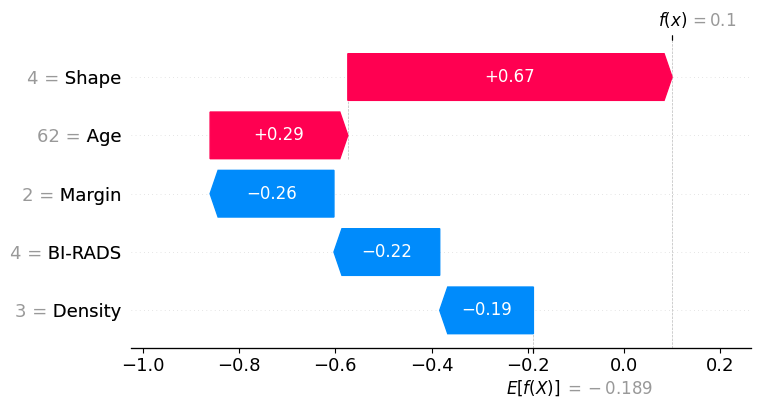

In [17]:
shap_values = explainer.shap_values(pd.DataFrame([x], columns=X_test.columns))
shap.initjs()
shap.plots.waterfall(shap.Explanation(values=shap_values[0], 
                                     base_values=explainer.expected_value, 
                                     data=x.values, 
                                     feature_names=X_test.columns))

Model przypisał obserwację do klasy 1, jednak decyzja jest niepewna, ponieważ suma ważonych cech z interceptem była blisko zera, dając prawdopodobieństwo klasy 1 tylko trochę większe od 0.50. 

- Największy pozytywny wpływ miały cechy: BI-RADS, Age i Shape.
- Cecha Density silnie obniżała sumę liniową, działając przeciwnie.
- Decyzja to efekt równowagi między cechami silnie pozytywnymi a jednym ujemnym czynnikiem.

Minimalna zmiana jednej cechy potrzebna do zmiany klasy jest odwrotnie proporcjonalna do jej współczynnika i przesuwa sumę liniową na drugą stronę progu decyzyjnego.

Próbkowanie wartości cech z nieznaczną nadwyżką ponad minimalne zmiany potwierdziło zmianę klasy zgodnie z przewidywaniami analitycznymi.

### Przykład 2

In [18]:
idx = random_indices[1]
x = X_test.iloc[idx]
linear_sum = np.dot(coef, x) + intercept
prob = 1 / (1 + np.exp(-linear_sum))
pred = model.predict(pd.DataFrame([x], columns=X_test.columns))[0]

print(f"Przykład 2 (indeks {idx} w zbiorze testowym):")
print(f"Wartości cech: BI-RADS={x.iloc[0]}, Age={x.iloc[1]}, Shape={x.iloc[2]}, Margin={x.iloc[3]}, Density={x.iloc[4]}")
print(f"Współczynniki: {coef}")
print(f"Wartości * współczynniki: {coef * x}")
print(f"Sumaryczna wartość liniowa (z interceptem): {linear_sum:.4f}")
print(f"Prawdopodobieństwo klasy 1: {prob:.4f}")
print(f"Przewidywana klasa: {pred}")

df_changes = minimal_change_to_flip_decision_logistic_regression(x, coef, intercept)
print("\nMinimalne zmiany wartości cech wymagane do zmiany decyzji modelu:")
print(df_changes)

Przykład 2 (indeks 15 w zbiorze testowym):
Wartości cech: BI-RADS=4, Age=58, Shape=2, Margin=1, Density=3
Współczynniki: [ 0.70888026  0.03563129  0.53040397  0.38980711 -1.21605076]
Wartości * współczynniki: BI-RADS    2.835521
Age        2.066615
Shape      1.060808
Margin     0.389807
Density   -3.648152
Name: 622, dtype: float64
Sumaryczna wartość liniowa (z interceptem): -1.4935
Prawdopodobieństwo klasy 1: 0.1834
Przewidywana klasa: 0

Minimalne zmiany wartości cech wymagane do zmiany decyzji modelu:
   Feature  Current Value  Coefficient  Required Change  Value After Change
0  BI-RADS              4     0.708880         2.106894            6.106894
1      Age             58     0.035631        41.916399           99.916399
2    Shape              2     0.530404         2.815845            4.815845
3   Margin              1     0.389807         3.831473            4.831473
4  Density              3    -1.216051        -1.228185            1.771815


In [19]:
sample_and_predict_changes_logistic_regression(x, coef, intercept, model, X_test, df_changes, pred)


Próbkowanie zmienionych cech i wynik predykcji:
- Cecha BI-RADS: zmiana o 2.1280, nowa wartość 6.1280
  Prawdopodobieństwo klasy 1 po zmianie: 0.5037
  Predykcja po zmianie: 1, zmiana klasy: TAK
- Cecha Age: zmiana o 42.3356, nowa wartość 100.3356
  Prawdopodobieństwo klasy 1 po zmianie: 0.5037
  Predykcja po zmianie: 1, zmiana klasy: TAK
- Cecha Shape: zmiana o 2.8440, nowa wartość 4.8440
  Prawdopodobieństwo klasy 1 po zmianie: 0.5037
  Predykcja po zmianie: 1, zmiana klasy: TAK
- Cecha Margin: zmiana o 3.8698, nowa wartość 4.8698
  Prawdopodobieństwo klasy 1 po zmianie: 0.5037
  Predykcja po zmianie: 1, zmiana klasy: TAK
- Cecha Density: zmiana o -1.2405, nowa wartość 1.7595
  Prawdopodobieństwo klasy 1 po zmianie: 0.5037
  Predykcja po zmianie: 1, zmiana klasy: TAK


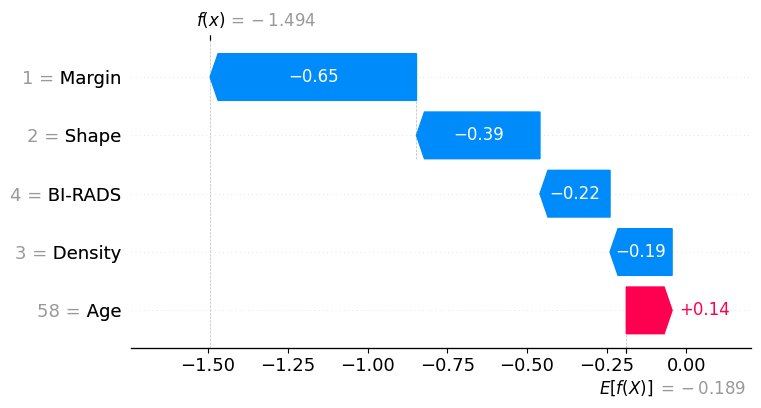

In [20]:
shap_values = explainer.shap_values(pd.DataFrame([x], columns=X_test.columns))
shap.initjs()
shap.plots.waterfall(shap.Explanation(values=shap_values[0], 
                                     base_values=explainer.expected_value, 
                                     data=x.values, 
                                     feature_names=X_test.columns))

Model przypisał obserwację do klasy 0 z dużą pewnością, ponieważ suma ważonych cech z interceptem była znacznie poniżej zera, dając prawdopodobieństwo klasy 1 około 0.18.

- Największy pozytywny wpływ miały cechy: BI-RADS, Age, Shape i Margin, jednak ich suma nie była wystarczająca.
- Cecha Density miała silny negatywny wpływ, jeszcze bardziej obniżając sumę liniową.
- Decyzja wynika z przewagi cech przeciwnych klasie 1.

Minimalna zmiana jednej cechy potrzebna do zmiany klasy jest odwrotnie proporcjonalna do jej współczynnika i wymaga przesunięcia sumy liniowej ponad próg decyzyjny.

Próbkowanie wartości cech z nieznaczną nadwyżką ponad minimalne zmiany potwierdziło zmianę klasy zgodnie z przewidywaniami analitycznymi.


### Przykład 3

In [21]:
idx = random_indices[2]
x = X_test.iloc[idx]
linear_sum = np.dot(coef, x) + intercept
prob = 1 / (1 + np.exp(-linear_sum))
pred = model.predict(pd.DataFrame([x], columns=X_test.columns))[0]

print(f"Przykład 3 (indeks {idx} w zbiorze testowym):")
print(f"Wartości cech: BI-RADS={x.iloc[0]}, Age={x.iloc[1]}, Shape={x.iloc[2]}, Margin={x.iloc[3]}, Density={x.iloc[4]}")
print(f"Współczynniki: {coef}")
print(f"Wartości * współczynniki: {coef * x}")
print(f"Sumaryczna wartość liniowa (z interceptem): {linear_sum:.4f}")
print(f"Prawdopodobieństwo klasy 1: {prob:.4f}")
print(f"Przewidywana klasa: {pred}")

df_changes = minimal_change_to_flip_decision_logistic_regression(x, coef, intercept)
print("\nMinimalne zmiany wartości cech wymagane do zmiany decyzji modelu:")
print(df_changes)

Przykład 3 (indeks 73 w zbiorze testowym):
Wartości cech: BI-RADS=5, Age=53, Shape=4, Margin=5, Density=3
Współczynniki: [ 0.70888026  0.03563129  0.53040397  0.38980711 -1.21605076]
Wartości * współczynniki: BI-RADS    3.544401
Age        1.888459
Shape      2.121616
Margin     1.949036
Density   -3.648152
Name: 479, dtype: float64
Sumaryczna wartość liniowa (z interceptem): 1.6572
Prawdopodobieństwo klasy 1: 0.8399
Przewidywana klasa: 1

Minimalne zmiany wartości cech wymagane do zmiany decyzji modelu:
   Feature  Current Value  Coefficient  Required Change  Value After Change
0  BI-RADS              5     0.708880        -2.337806            2.662194
1      Age             53     0.035631       -46.510372            6.489628
2    Shape              4     0.530404        -3.124458            0.875542
3   Margin              5     0.389807        -4.251397            0.748603
4  Density              3    -1.216051         1.362792            4.362792


In [22]:
sample_and_predict_changes_logistic_regression(x, coef, intercept, model, X_test, df_changes, pred)


Próbkowanie zmienionych cech i wynik predykcji:
- Cecha BI-RADS: zmiana o -2.3612, nowa wartość 2.6388
  Prawdopodobieństwo klasy 1 po zmianie: 0.4959
  Predykcja po zmianie: 0, zmiana klasy: TAK
- Cecha Age: zmiana o -46.9755, nowa wartość 6.0245
  Prawdopodobieństwo klasy 1 po zmianie: 0.4959
  Predykcja po zmianie: 0, zmiana klasy: TAK
- Cecha Shape: zmiana o -3.1557, nowa wartość 0.8443
  Prawdopodobieństwo klasy 1 po zmianie: 0.4959
  Predykcja po zmianie: 0, zmiana klasy: TAK
- Cecha Margin: zmiana o -4.2939, nowa wartość 0.7061
  Prawdopodobieństwo klasy 1 po zmianie: 0.4959
  Predykcja po zmianie: 0, zmiana klasy: TAK
- Cecha Density: zmiana o 1.3764, nowa wartość 4.3764
  Prawdopodobieństwo klasy 1 po zmianie: 0.4959
  Predykcja po zmianie: 0, zmiana klasy: TAK


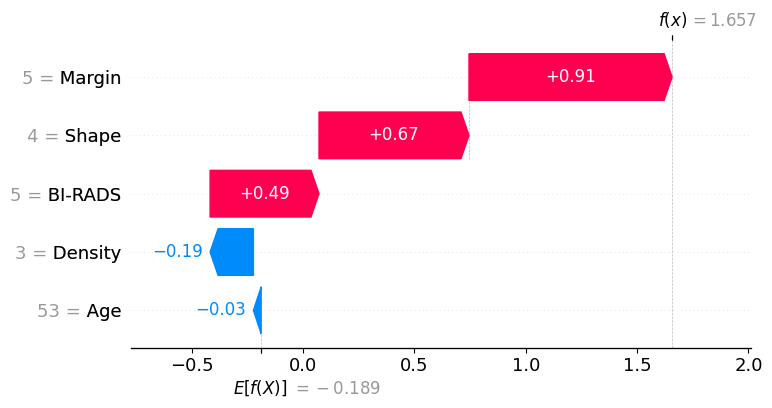

In [23]:
shap_values = explainer.shap_values(pd.DataFrame([x], columns=X_test.columns))
shap.initjs()
shap.plots.waterfall(shap.Explanation(values=shap_values[0], 
                                     base_values=explainer.expected_value, 
                                     data=x.values, 
                                     feature_names=X_test.columns))

Model przypisał obserwację do klasy 1 z wysokim prawdopodobieństwem, ponieważ suma ważonych cech z interceptem była wyraźnie powyżej zera.

- Największy pozytywny wpływ miały cechy: BI-RADS, Shape, Margin oraz Age, które znacząco podniosły sumę liniową.
- Cecha Density miała silny negatywny wpływ, częściowo obniżając sumę, ale nie na tyle, by zmienić decyzję.
- Decyzja modelu wynika z przewagi pozytywnych wartości cech nad negatywnym wpływem Density.

Minimalna zmiana wartości cech potrzebna do zmiany decyzji modelu jest odwrotnie proporcjonalna do ich współczynników i oznacza przesunięcie sumy liniowej poniżej progu decyzyjnego.

Próbkowanie wartości cech z niewielką nadwyżką ponad minimalne zmiany potwierdziło zmianę klasy zgodnie z przewidywaniami analitycznymi.

## Interpretacja modelu

Regresja logistyczna przewiduje prawdopodobieństwo wystąpienia złośliwego guza piersi (klasa 1) na podstawie wartości cech. Współczynniki modelu oraz wartości SHAP pokazują, że największy wpływ na decyzję mają cechy BI-RADS (najsilniejszy, pozytywny wpływ), Density (negatywny wpływ), a w mniejszym stopniu Shape i Margin. Wiek (Age) ma niewielką wagę, ale ze względu na dużą skalę wartości, jego wpływ na decyzję modelu jest zauważalny i częściowo rekompensuje niski współczynnik.

Wszystkie cechy mają charakter monotoniczny, co jest zgodne z naturą modelu liniowego — wyższe wartości niektórych cech zwiększają prawdopodobieństwo (BI-RADS, Shape, Margin, Age), inne je obniżają (Density). Nie zaobserwowano progów preferencji ani obszarów nierozróżnialności — wpływ cech zmienia się płynnie.

### Wizualizacja funkcji cząstkowych zależności

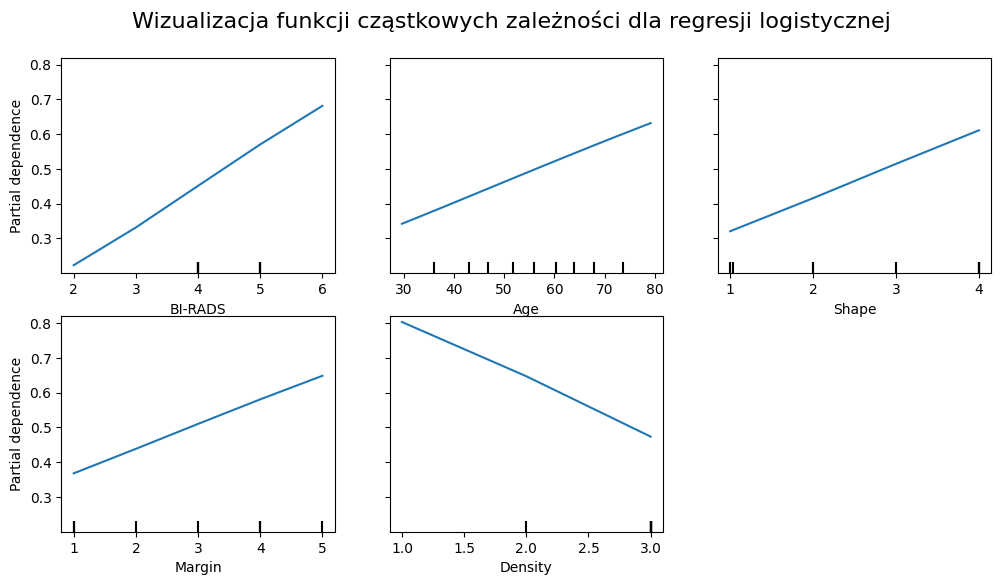

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(model, X_test, features, ax=ax, grid_resolution=50)
plt.suptitle('Wizualizacja funkcji cząstkowych zależności dla regresji logistycznej', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

Wykresy funkcji cząstkowych zależności pokazują, jak zmiana wartości poszczególnych cech wpływa na przewidywane prawdopodobieństwo przypisania do klasy 1, przy założeniu stałości pozostałych cech. Zależności mają kształt niemal liniowy, co jest zgodne z liniowym charakterem regresji logistycznej.

Wyniki uzyskane za pomocą tej techniki potwierdzają wcześniejsze wnioski dotyczące wpływu cech na decyzje modelu. Cecha BI-RADS ma największy wpływ, a Density działa w przeciwnym kierunku, co jest spójne z analizą współczynników regresji i wartości SHAP.


---

## ANN-MCDA: ANN-UTADIS

Poniżej importujemy niezbędne moduły zaprezentowane na zajęciach laboratoryjnych, które pozwalają na implementację modelu ANN-UTADIS oraz jego analizę i interpretację.

In [25]:
class CriterionLayerCombine(nn.Module):

    def __init__(
        self,
        num_criteria: int,
        num_hidden_components: int,
        min_weight: float = 0.001,
        **kwargs
    ):
        super().__init__()
        self.min_weight = min_weight
        self.weight = nn.Parameter(
            torch.FloatTensor(num_hidden_components, num_criteria)
        )
        self.reset_parameters()

    def reset_parameters(self) -> None:
        nn.init.uniform_(self.weight, 0.2, 1.0)
        self.weight.data = self.weight.data / torch.sum(self.weight.data)

    def compute_weight(self) -> torch.Tensor:
        with torch.no_grad():
            self.weight.data[self.weight.data < 0] = self.min_weight
        return self.weight

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return (input * self.compute_weight()).sum(1)


In [26]:
class CriterionLayerSpread(nn.Module):
    def __init__(
        self,
        num_criteria: int,
        num_hidden_components: int,
        input_range: Tuple[float, float] = (0, 1),
        normalize_bias: bool = False,
        **kwargs
    ) -> None:
        super().__init__()
        self.num_criteria = num_criteria
        input_range = (-input_range[0], -input_range[1])
        self.max_bias = max(input_range)
        self.min_bias = min(input_range)
        self.normalize_bias = normalize_bias
        self.bias = nn.Parameter(torch.FloatTensor(num_hidden_components, num_criteria))
        self.weight = nn.Parameter(
            torch.FloatTensor(num_hidden_components, num_criteria)
        )
        self.reset_parameters()
        self.min_w = 0

    def reset_parameters(self) -> None:
        nn.init.uniform_(self.weight, 1, 10.0)
        nn.init.uniform_(self.bias, self.min_bias, self.max_bias)

    def compute_bias(self) -> torch.Tensor:
        if self.normalize_bias:
            return torch.clamp(self.bias, self.min_bias, self.max_bias)
        else:
            return self.bias

    def compute_weight(self) -> torch.Tensor:
        # return torch.clamp(self.weight, 0.0)
        with torch.no_grad():
            self.weight.data[self.weight.data < 0] = self.min_w
        return self.weight

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = input.view(-1, 1, self.num_criteria)
        return (x + self.compute_bias()) * self.compute_weight()


In [27]:
class LeakyHardSigmoid(nn.Module):

    def __init__(self, slope: float = 0.01, **kwargs):
        super().__init__()
        self.slope = slope

    def set_slope(self, val: float) -> None:
        self.slope = val

    def forward(self, input):
        return F.leaky_relu(1.0 - F.leaky_relu(1 - input, self.slope), self.slope)


In [28]:
class MonotonicLayer(nn.Sequential):
    def __init__(
        self,
        num_criteria: int,
        num_hidden_components: int,
        slope: float = 0.01,
        **kwargs
    ):
        super().__init__()
        self.criterion_layer_spread = CriterionLayerSpread(
            num_criteria, num_hidden_components, **kwargs
        )
        self.activation_function = LeakyHardSigmoid(slope=slope, **kwargs)
        self.criterion_layer_combine = CriterionLayerCombine(
            num_criteria, num_hidden_components, **kwargs
        )

    def set_slope(self, val: float) -> None:
        self.activation_function.set_slope(val)

    def forward(self, x):
        for module in self._modules.values():
            x = module(x)
        return x


In [29]:
class Uta(nn.Sequential):

    def __init__(
        self,
        num_criteria: int,
        num_hidden_components: int,
        slope: float = 0.01,
        **kwargs
    ):
        super().__init__()
        self.monotonic_layer = MonotonicLayer(
            num_criteria, num_hidden_components, slope, **kwargs
        )

    def set_slope(self, val: float) -> None:
        self.monotonic_layer.set_slope(val)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.monotonic_layer(input)
        return x.sum(1)


In [30]:
class Hook:

    def __init__(self, layer: torch.nn.Module, func: callable):
        self.hook = layer.register_forward_hook(partial(func, self))

    def remove(self):
        self.hook.remove()

    def __del__(self):
        self.remove()


def append_output(hook: Hook, mod: torch.nn.Module, input: Any, output: torch.Tensor):
    if not hasattr(hook, "stats"):
        hook.stats = []
    if not hasattr(hook, "name"):
        hook.name = mod.__class__.__name__
    data = hook.stats
    data.append(output.data)


def get_simple_input(val: float, num_criteria: int) -> torch.Tensor:

    input_tensor = torch.full((1, 1, num_criteria), val, dtype=torch.float)
    return input_tensor.cpu()


class NumpyDataset(Dataset):
    def __init__(self, data: np.array, targets: np.array):
        self.data = torch.Tensor(data)
        self.targets = torch.LongTensor(targets.astype(int))

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.data[index]
        y = self.targets[index]
        return x, y

    def __len__(self) -> int:
        return len(self.data)


def CreateDataLoader(data: np.array, targets: np.array) -> DataLoader:
    dataset = NumpyDataset(data, targets)
    return DataLoader(dataset, batch_size=len(dataset))


def Regret(output: torch.FloatTensor, target: torch.LongTensor) -> torch.FloatTensor:
    loss_fn = torch.nn.BCEWithLogitsLoss()
    return loss_fn(output.view(-1), target.float())

def Accuracy(output: torch.FloatTensor, target: torch.LongTensor) -> torch.FloatTensor:
    probs = torch.sigmoid(output)
    preds = (probs > 0.5).int()
    return (target == preds).float().mean().item()

def AUC(output: torch.FloatTensor, target: torch.LongTensor) -> torch.FloatTensor:
    probs = torch.sigmoid(output).detach().cpu().numpy()
    targets = target.detach().cpu().numpy()
    return roc_auc_score(targets, probs)


class ScoreTracker:
    def __init__(self):
        self.losses = []
        self.auc_scores = []
        self.acc_scores = []
        self.f1_scores = []

    def append(self, loss: float, auc: float, acc: float, f1: float = None) -> None:
        self.losses.append(loss)
        self.auc_scores.append(auc)
        self.acc_scores.append(acc)
        if f1 is not None:
            self.f1_scores.append(f1)

    def add(self, outputs: torch.FloatTensor, labels: torch.LongTensor) -> None:
        probs = torch.sigmoid(outputs).detach().cpu().numpy()
        preds = (probs > 0.5).astype(int)
        y_true = labels.detach().cpu().numpy()

        loss = float(Regret(outputs, labels).item())
        auc = AUC(outputs, labels)
        acc = Accuracy(outputs, labels)
        f1 = f1_score(y_true, preds)

        self.losses.append(loss)
        self.auc_scores.append(auc)
        self.acc_scores.append(acc)
        self.f1_scores.append(f1)


def Train(
    model: torch.nn.Module,
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    path: str,
    lr: float = 0.01,
    epoch_nr: int = 200,
    slope_decrease: bool = False,
) -> Tuple[float, float, ScoreTracker, ScoreTracker]:
    optimizer = optim.AdamW(
        model.parameters(), lr=lr, betas=(0.9, 0.99), weight_decay=0.01
    )
    # Add a learninge rate scheduler to the optimizer
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epoch_nr
    )
    best_acc = 0.0
    best_auc = 0.0
    stats_train = ScoreTracker()
    stats_test = ScoreTracker()
    # Decrease the slope of the leaky hard sigmoid activation function in each epoch
    slopes = np.linspace(0.01, 0.003, epoch_nr)
    for epoch in tqdm(range(epoch_nr)):
        if slope_decrease:
            model.set_slope(slopes[epoch])
        for _, data in enumerate(train_dataloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = Regret(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            probs = torch.sigmoid(outputs).detach().cpu().numpy()
            preds = (probs > 0.5).astype(int)
            y_true = labels.detach().cpu().numpy()
            f1 = f1_score(y_true, preds)

            acc = Accuracy(outputs, labels)
            auc = AUC(outputs, labels)
            stats_train.append(loss.item(), auc, acc, f1)

        with torch.no_grad():
            for _, data in enumerate(test_dataloader, 0):
                inputs, labels = data
                outputs = model(inputs)
                stats_test.add(outputs, labels)

        # Save the model if the accuracy is better than the previous best
        if acc > best_acc:
            best_acc = acc
            best_auc = auc

            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                },
                path,
            )

    return (
        best_acc,
        best_auc,
        stats_train,
        stats_test,
    )

In [31]:
class ThresholdLayer(nn.Module):

    def __init__(self, threshold: float = None, requires_grad: bool = True):
        super().__init__()
        if threshold is None:
            self.threshold = nn.Parameter(
                torch.FloatTensor(1).uniform_(0.1, 0.9), requires_grad=requires_grad
            )
        else:
            self.threshold = nn.Parameter(
                torch.FloatTensor([threshold]), requires_grad=requires_grad
            )

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        return x - self.threshold

In [32]:
class NormLayer(nn.Module):

    def __init__(self, method_instance: torch.nn.Module, num_criteria: int):
        super().__init__()
        self.method_instance = method_instance
        self.num_criteria = num_criteria
        self.thresholdLayer = ThresholdLayer(0.5)

    def set_slope(self, slope: float):
        self.method_instance.set_slope(slope)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        self.out = self.method_instance(input)

        zero_input = torch.zeros(self.num_criteria).view(1, 1, -1).to(self.out.device)
        zero = self.method_instance(zero_input)
        one = self.method_instance(zero_input + 1)

        self.out = (self.out - zero) / (one - zero)
        return self.thresholdLayer(self.out)

### Przygotowanie danych

In [33]:
df = pd.read_csv('data/mammographic.csv')
df = df[df.iloc[:, 0] != 55]

num_criteria = 5
feature_names = df.columns[:num_criteria].tolist()

data_input = df.iloc[:, :num_criteria]
data_target = df.iloc[:, num_criteria]

data_input = data_input.values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(
    data_input, data_target.values, test_size=0.2, random_state=1234
)

train_dataloader = CreateDataLoader(X_train, y_train)
test_dataloader = CreateDataLoader(X_test, y_test)

### Trenowanie modelu

In [34]:
num_hidden_components = 30

uta = Uta(num_criteria, num_hidden_components)
model = NormLayer(uta, num_criteria)

UTA_PATH = "models/ann_utadis.pt"

(
    best_acc,
    best_auc,
    stats_train,
    stats_test,
) = Train(
    model,
    train_dataloader,
    test_dataloader,
    UTA_PATH,
    epoch_nr=2000,
    lr=0.001,
    slope_decrease=True
)

100%|██████████| 2000/2000 [01:21<00:00, 24.50it/s]


### Metryki

In [35]:
print("=== Final Evaluation Metrics ===")
print(f"Train Accuracy: {round(stats_train.acc_scores[-1], 4)}")
print(f"Test Accuracy:  {round(stats_test.acc_scores[-1], 4)}")
print(f"Train AUC:      {round(stats_train.auc_scores[-1], 4)}")
print(f"Test AUC:       {round(stats_test.auc_scores[-1], 4)}")
print(f"Train F1:       {round(stats_train.f1_scores[-1], 4)}")
print(f"Test F1:        {round(stats_test.f1_scores[-1], 4)}")

=== Final Evaluation Metrics ===
Train Accuracy: 0.7662
Test Accuracy:  0.8313
Train AUC:      0.837
Test AUC:       0.8995
Train F1:       0.7936
Test F1:        0.825


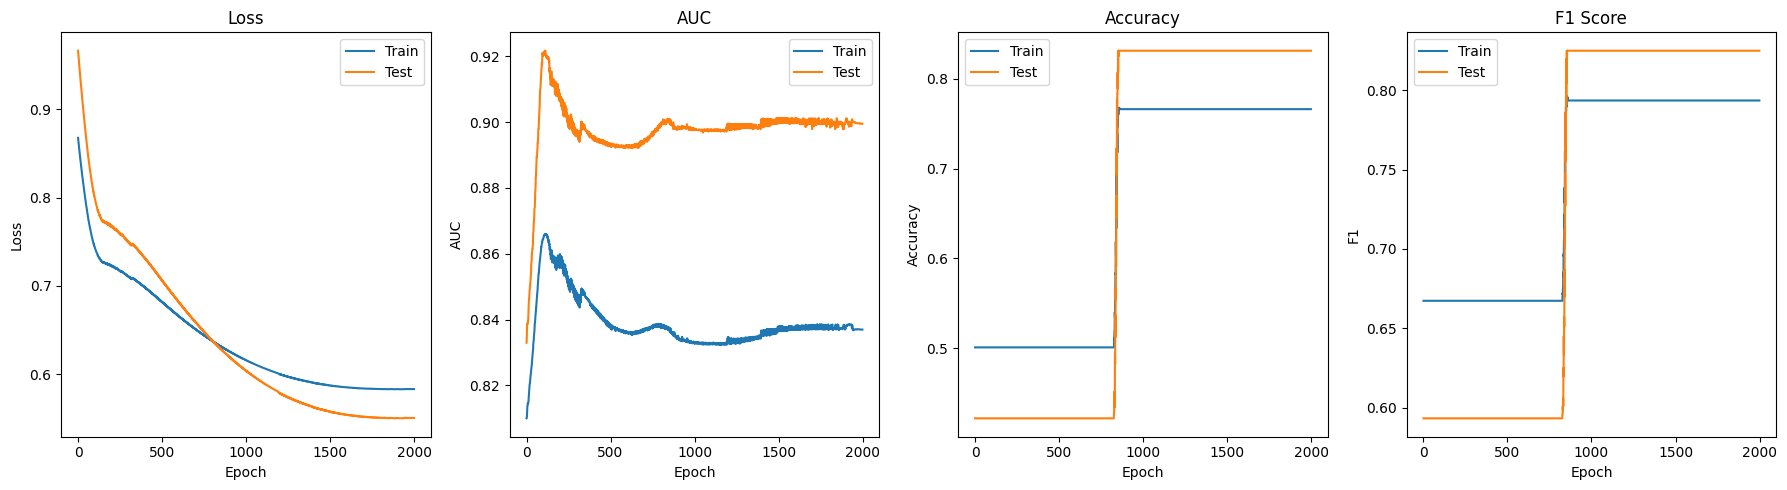

In [36]:
fig = plt.figure(figsize=(18, 5))

# Loss
ax = fig.add_subplot(1, 4, 1)
ax.plot(stats_train.losses, label='Train')
ax.plot(stats_test.losses, label='Test')
ax.set_title('Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

# AUC
ax = fig.add_subplot(1, 4, 2)
ax.plot(stats_train.auc_scores, label='Train')
ax.plot(stats_test.auc_scores, label='Test')
ax.set_title('AUC')
ax.set_xlabel('Epoch')
ax.set_ylabel('AUC')
ax.legend()

# Accuracy
ax = fig.add_subplot(1, 4, 3)
ax.plot(stats_train.acc_scores, label='Train')
ax.plot(stats_test.acc_scores, label='Test')
ax.set_title('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()

# F1
ax = fig.add_subplot(1, 4, 4)
ax.plot(stats_train.f1_scores, label='Train')
ax.plot(stats_test.f1_scores, label='Test')
ax.set_title('F1 Score')
ax.set_xlabel('Epoch')
ax.set_ylabel('F1')
ax.legend()

plt.tight_layout()
plt.show()

- Model zaczął poprawnie różnicować klasy dopiero po zwiększeniu liczby iteracji – dopiero wtedy prawdopodobieństwa klasyfikacji zaczęły spadać poniżej 0.50, co świadczy o dojrzewaniu modelu w procesie uczenia.  
- Testowe metryki (AUC, Accuracy) są porównywalne lub nawet nieco lepsze niż treningowe, co sugeruje brak przeuczenia i dobre zdolności generalizacyjne modelu.  
- Wysoka wartość AUC na zbiorze testowym potwierdza, że model skutecznie rozdziela klasy przy różnych progach decyzyjnych.  
- Nieco niższy F1 na zbiorze testowym wskazuje, że mimo dobrej ogólnej skuteczności, model może mieć trudności z równoważeniem precyzji i czułości w praktyce.  
- Gwałtowne zwiększenie accuracy nastąpiło dopiero po osiągnięciu odpowiedniego poziomu iteracji, co potwierdza, że zbyt wczesne zatrzymanie procesu uczenia skutkowałoby niedostatecznym dopasowaniem modelu.


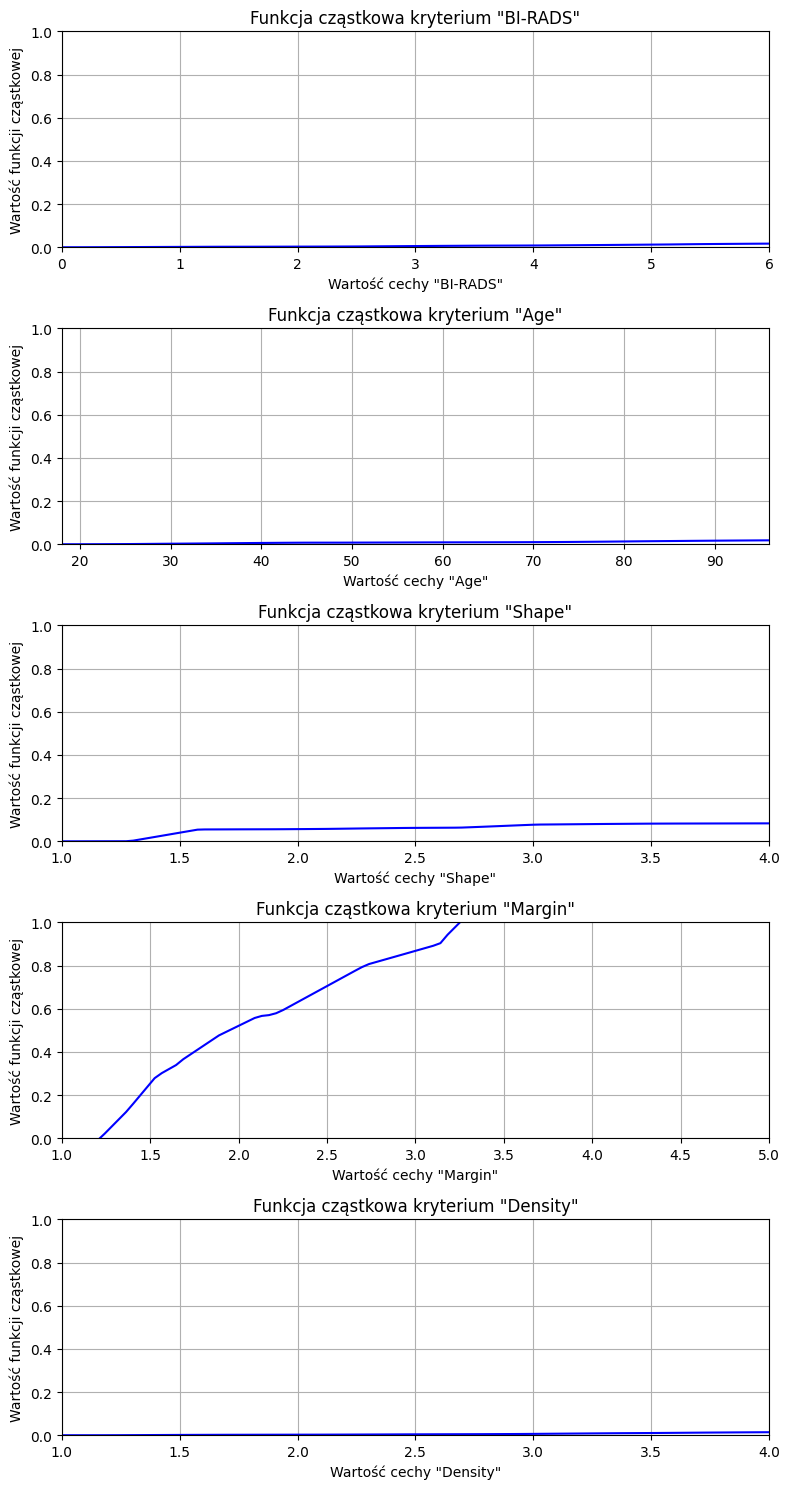

In [37]:
def plot_partial_functions_uta_dis(monotonic_layer, data_input, feature_names):
    num_criteria = data_input.shape[1]
    feature_mins = data_input.min(axis=0)
    feature_maxs = data_input.max(axis=0)

    fig, axes = plt.subplots(num_criteria, 1, figsize=(8, 3 * num_criteria))
    if num_criteria == 1:
        axes = [axes]

    for crit in range(num_criteria):
        min_val = feature_mins[crit]
        max_val = feature_maxs[crit]

        x_vals = torch.linspace(min_val, max_val, 100).unsqueeze(1)
        x_scaled = (x_vals - min_val) / (max_val - min_val)
        x_input = torch.zeros(100, num_criteria)
        x_input[:, crit] = x_scaled.squeeze()

        with torch.no_grad():
            spread_out = monotonic_layer.criterion_layer_spread(x_input)
            activated = monotonic_layer.activation_function(spread_out)
            combined = monotonic_layer.criterion_layer_combine(activated)

        axes[crit].plot(x_vals.numpy(), combined[:, crit].numpy(), color='blue')
        axes[crit].set_title(f'Funkcja cząstkowa kryterium "{feature_names[crit]}"')
        axes[crit].set_xlabel(f'Wartość cechy "{feature_names[crit]}"')
        axes[crit].set_ylabel('Wartość funkcji cząstkowej')
        axes[crit].set_xlim(min_val, max_val)
        axes[crit].set_ylim(0, 1)
        axes[crit].grid(True)

    plt.tight_layout()
    plt.show()

plot_partial_functions_uta_dis(model.method_instance.monotonic_layer, data_input, df.columns[:num_criteria])

## Interpretacja wizualizacji

Okazuje się, że najważniejszą cechą wyuczoną przez sieć neuronową wspomagającą metodę UTA-DIS jest kryterium Margin. To właśnie ono odpowiada za największą zmianę w funkcji użyteczności pomiędzy ocenami 1 i 2, a następnie jego wpływ rośnie w przybliżeniu liniowo. Drugim istotnym kryterium jest Shape, które przypisuje ocenie 1 bardzo niską wartość funkcji użyteczności, natomiast dla wyższych ocen jego wpływ pozostaje niemal stały. Pozostałe kryteria mają jedynie marginalny wpływ na końcową wartość funkcji użyteczności.

## Wyjaśnienie wybranych decyzji

In [38]:
np.random.seed(42)
random_indices = np.random.choice(len(X_test), 3, replace=False)
background_data = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

In [39]:
def explain_decision_uta_dis(model, input_tensor, feature_names):
    model.eval()
    input_tensor = input_tensor.clone().detach().requires_grad_(True)
    
    output = model(input_tensor)
    prob = torch.sigmoid(output).item()
    pred_class = int(prob > 0.5)
    
    output.backward()
    
    grads = input_tensor.grad[0].detach().numpy()
    print(f"Prawdopodobieństwo klasy 1: {prob:.4f}")
    print(f"Predykcja klasy: {pred_class}")
    print("Wpływ cech (gradienty):")
    for i, grad in enumerate(grads):
        print(f"- {feature_names[i]}: {grad:.6f}")
    
    return grads, pred_class


In [40]:
def minimal_change_to_flip_decision_uta_dis(model, input_tensor, feature_names):
    model.eval()
    input_tensor = input_tensor.clone().detach().requires_grad_(True)
    output = model(input_tensor)

    logit = output.item()
    prob = torch.sigmoid(output).item()
    pred_class = int(prob > 0.5)

    output.backward()
    grads = input_tensor.grad[0].detach().numpy()

    margin = logit

    changes = []
    for i in range(input_tensor.shape[1]):
        grad = grads[i]
        if grad == 0:
            delta = np.inf
        else:
            delta = -margin / grad

        changes.append({
            'Feature': feature_names[i],
            'Current Value': input_tensor[0, i].item(),
            'Gradient': grad,
            'Required Change': delta,
            'New Value': input_tensor[0, i].item() + delta,
        })

    df = pd.DataFrame(changes)
    return df, pred_class

In [41]:
def sample_and_predict_changes_uta_dis(model, input_tensor, df_changes, feature_names):
    model.eval()
    original_output = model(input_tensor)
    original_prob = torch.sigmoid(original_output).item()
    original_pred = int(original_prob > 0.5)

    print(f"Oryginalna klasa: {original_pred}\n")
    
    for _, row in df_changes.iterrows():
        if np.isinf(row['Required Change']):
            print(f"- Cecha {row['Feature']} ma zerowy gradient, brak wpływu na predykcję.")
            continue
        
        modified_input = input_tensor.clone().detach()
        delta = row['Required Change'] * 1.01
        idx = feature_names.index(row['Feature'])
        modified_input[0, idx] += delta
        
        with torch.no_grad():
            new_output = model(modified_input)
            new_prob = torch.sigmoid(new_output).item()
            new_pred = int(new_prob > 0.5)
        changed = "TAK" if new_pred != original_pred else "NIE"
        print(f"- Cecha {row['Feature']}: zmiana o {delta:.4f}, nowa wartość: {modified_input[0, idx].item():.4f}")
        print(f"  Nowa predykcja: {new_pred}, zmiana klasy: {changed}")

In [42]:
def explain_with_shap_UTA_DIS(model, input_tensor, background_data, feature_names):
    model.eval()

    def model_predict(x_numpy):
        x_tensor = torch.tensor(x_numpy, dtype=torch.float32)
        with torch.no_grad():
            logits = model(x_tensor)
            probs = torch.sigmoid(logits).numpy()
        return probs

    background_df = pd.DataFrame(background_data, columns=feature_names)
    
    x_np = np.array(x).reshape(-1)
    x_df = pd.DataFrame([x_np], columns=feature_names)

    explainer = shap.KernelExplainer(model_predict, background_df)
    shap_values = explainer.shap_values(x_df)

    shap.initjs()
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values[0],
            base_values=explainer.expected_value,
            data=x_df.values[0],
            feature_names=feature_names
        )
    )


### Przykład 1

In [43]:
x0 = torch.tensor(X_test[random_indices[0]:random_indices[0]+1], dtype=torch.float32)
print(f"\n====== Przykład 1 (indeks {random_indices[0]}) ======")
grads0, pred0 = explain_decision_uta_dis(model, x0, feature_names)
df_changes0, pred0 = minimal_change_to_flip_decision_uta_dis(model, x0, feature_names)
print("\nMinimalne zmiany cech potrzebne do zmiany decyzji:")
print(df_changes0)


====== Przykład 1 (indeks 100) ======
Prawdopodobieństwo klasy 1: 0.3885
Predykcja klasy: 0
Wpływ cech (gradienty):
- BI-RADS: 0.000100
- Age: 0.000132
- Shape: 0.000891
- Margin: 0.036691
- Density: 0.000072

Minimalne zmiany cech potrzebne do zmiany decyzji:
   Feature  Current Value  Gradient  Required Change    New Value
0  BI-RADS            4.0  0.000100      4532.656085  4536.656085
1      Age           26.0  0.000132      3448.543808  3474.543808
2    Shape            1.0  0.000891       509.359083   510.359083
3   Margin            1.0  0.036691        12.367721    13.367721
4  Density            3.0  0.000072      6295.490110  6298.490110


In [44]:
print("\nPróbkowanie zmian i ponowna predykcja:")
sample_and_predict_changes_uta_dis(model, x0, df_changes0, feature_names)


Próbkowanie zmian i ponowna predykcja:
Oryginalna klasa: 0

- Cecha BI-RADS: zmiana o 4577.9826, nowa wartość: 4581.9824
  Nowa predykcja: 1, zmiana klasy: TAK
- Cecha Age: zmiana o 3483.0292, nowa wartość: 3509.0293
  Nowa predykcja: 1, zmiana klasy: TAK
- Cecha Shape: zmiana o 514.4527, nowa wartość: 515.4527
  Nowa predykcja: 1, zmiana klasy: TAK
- Cecha Margin: zmiana o 12.4914, nowa wartość: 13.4914
  Nowa predykcja: 1, zmiana klasy: TAK
- Cecha Density: zmiana o 6358.4450, nowa wartość: 6361.4448
  Nowa predykcja: 1, zmiana klasy: TAK


  0%|          | 0/1 [00:00<?, ?it/s]

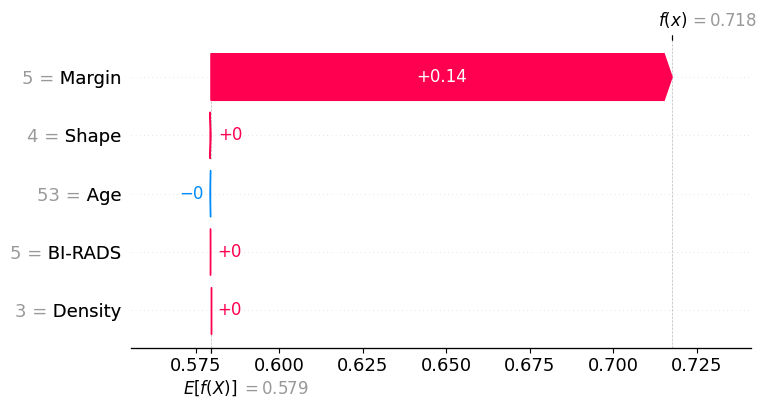

In [45]:
explain_with_shap_UTA_DIS(model, x0, background_data, feature_names)

Model nauczył się podejmować decyzję głównie na podstawie cechy Margin. W analizowanym przypadku, to właśnie ta cecha miała największy wpływ na klasyfikację próbki do klasy 0, co zostało potwierdzone przez wartości współczynników oraz analizę SHAP.

Próbkowanie wartości cech z nieznaczną nadwyżką ponad minimalne zmiany potwierdziło zmianę klasy zgodnie z przewidywaniami analitycznymi. Oznacza to, że minimalna modyfikacja jednej kluczowej cechy może skutecznie wpłynąć na decyzję modelu, jednak w tym konkretnym przypadku wartości wyliczone analitycznie były niemożliwe do osiągnięcia w praktyce.

### Przykład 2

In [46]:
x1 = torch.tensor(X_test[random_indices[1]:random_indices[1]+1], dtype=torch.float32)
print(f"\n====== Przykład 2 (indeks {random_indices[1]}) ======")
grads1, pred1 = explain_decision_uta_dis(model, x1, feature_names)
df_changes1, pred1 = minimal_change_to_flip_decision_uta_dis(model, x1, feature_names)
print("\nMinimalne zmiany cech potrzebne do zmiany decyzji:")
print(df_changes1)


====== Przykład 2 (indeks 136) ======
Prawdopodobieństwo klasy 1: 0.7177
Predykcja klasy: 1
Wpływ cech (gradienty):
- BI-RADS: 0.000100
- Age: 0.000132
- Shape: 0.000891
- Margin: 0.036691
- Density: 0.000072

Minimalne zmiany cech potrzebne do zmiany decyzji:
   Feature  Current Value  Gradient  Required Change     New Value
0  BI-RADS            5.0  0.000100     -9320.703900  -9315.703900
1      Age           55.0  0.000132     -7091.395226  -7036.395226
2    Shape            4.0  0.000891     -1047.417916  -1043.417916
3   Margin            5.0  0.036691       -25.432299    -20.432299
4  Density            3.0  0.000072    -12945.698532 -12942.698532


In [47]:
print("\nPróbkowanie zmian i ponowna predykcja:")
sample_and_predict_changes_uta_dis(model, x1, df_changes1, feature_names)


Próbkowanie zmian i ponowna predykcja:
Oryginalna klasa: 1

- Cecha BI-RADS: zmiana o -9413.9109, nowa wartość: -9408.9111
  Nowa predykcja: 0, zmiana klasy: TAK
- Cecha Age: zmiana o -7162.3092, nowa wartość: -7107.3091
  Nowa predykcja: 0, zmiana klasy: TAK
- Cecha Shape: zmiana o -1057.8921, nowa wartość: -1053.8921
  Nowa predykcja: 0, zmiana klasy: TAK
- Cecha Margin: zmiana o -25.6866, nowa wartość: -20.6866
  Nowa predykcja: 0, zmiana klasy: TAK
- Cecha Density: zmiana o -13075.1555, nowa wartość: -13072.1553
  Nowa predykcja: 0, zmiana klasy: TAK


  0%|          | 0/1 [00:00<?, ?it/s]

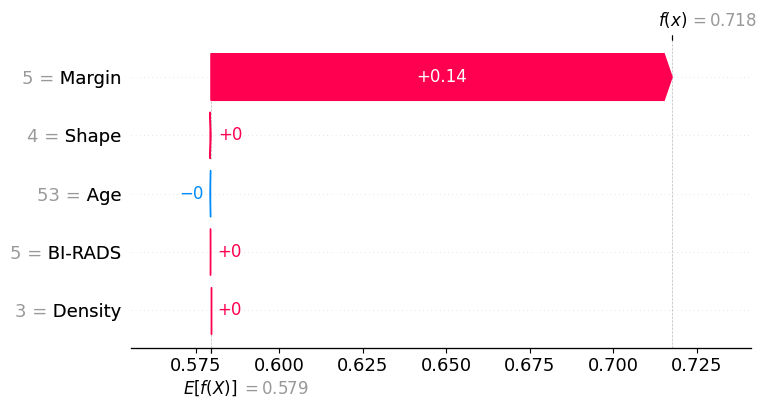

In [48]:
explain_with_shap_UTA_DIS(model, x1, background_data, feature_names)

Model nauczył się podejmować decyzję głównie na podstawie cechy Margin. W analizowanym przypadku, to właśnie ta cecha miała największy wpływ na klasyfikację próbki do klasy 1, co zostało potwierdzone przez wartości współczynników oraz analizę SHAP.

Próbkowanie wartości cech z nieznaczną nadwyżką ponad minimalne zmiany potwierdziło zmianę klasy zgodnie z przewidywaniami analitycznymi. Oznacza to, że minimalna modyfikacja jednej kluczowej cechy może skutecznie wpłynąć na decyzję modelu, jednak w tym konkretnym przypadku wartości wyliczone analitycznie były niemożliwe do osiągnięcia w praktyce.

### Przykład 3

In [49]:
x2 = torch.tensor(X_test[random_indices[2]:random_indices[2]+1], dtype=torch.float32)
print(f"\n====== Przykład 3 (indeks {random_indices[2]}) ======")
grads2, pred2 = explain_decision_uta_dis(model, x2, feature_names)
df_changes2, pred2 = minimal_change_to_flip_decision_uta_dis(model, x2, feature_names)
print("\nMinimalne zmiany cech potrzebne do zmiany decyzji:")
print(df_changes2)


====== Przykład 3 (indeks 78) ======
Prawdopodobieństwo klasy 1: 0.3894
Predykcja klasy: 0
Wpływ cech (gradienty):
- BI-RADS: 0.000100
- Age: 0.000132
- Shape: 0.000891
- Margin: 0.036691
- Density: 0.000072

Minimalne zmiany cech potrzebne do zmiany decyzji:
   Feature  Current Value  Gradient  Required Change    New Value
0  BI-RADS            4.0  0.000100      4493.224362  4497.224362
1      Age           56.0  0.000132      3418.543291  3474.543291
2    Shape            1.0  0.000891       504.927927   505.927927
3   Margin            1.0  0.036691        12.260128    13.260128
4  Density            3.0  0.000072      6240.722658  6243.722658


In [50]:
print("\nPróbkowanie zmian i ponowna predykcja:")
sample_and_predict_changes_uta_dis(model, x2, df_changes2, feature_names)


Próbkowanie zmian i ponowna predykcja:
Oryginalna klasa: 0

- Cecha BI-RADS: zmiana o 4538.1566, nowa wartość: 4542.1567
  Nowa predykcja: 1, zmiana klasy: TAK
- Cecha Age: zmiana o 3452.7287, nowa wartość: 3508.7288
  Nowa predykcja: 1, zmiana klasy: TAK
- Cecha Shape: zmiana o 509.9772, nowa wartość: 510.9772
  Nowa predykcja: 1, zmiana klasy: TAK
- Cecha Margin: zmiana o 12.3827, nowa wartość: 13.3827
  Nowa predykcja: 1, zmiana klasy: TAK
- Cecha Density: zmiana o 6303.1299, nowa wartość: 6306.1299
  Nowa predykcja: 1, zmiana klasy: TAK


  0%|          | 0/1 [00:00<?, ?it/s]

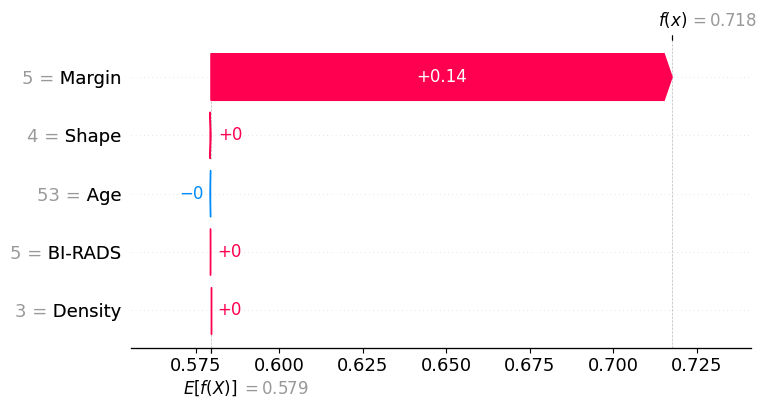

In [51]:
explain_with_shap_UTA_DIS(model, x1, background_data, feature_names)

Model nauczył się podejmować decyzję głównie na podstawie cechy Margin. W analizowanym przypadku, to właśnie ta cecha miała największy wpływ na klasyfikację próbki do klasy 1, co zostało potwierdzone przez wartości współczynników oraz analizę SHAP.

Próbkowanie wartości cech z nieznaczną nadwyżką ponad minimalne zmiany potwierdziło zmianę klasy zgodnie z przewidywaniami analitycznymi. Oznacza to, że minimalna modyfikacja jednej kluczowej cechy może skutecznie wpłynąć na decyzję modelu, jednak w tym konkretnym przypadku wartości wyliczone analitycznie były niemożliwe do osiągnięcia w praktyce.

## Interpretacja modelu

Margin: wpływ na dokładność = 0.2530
BI-RADS: wpływ na dokładność = 0.0000
Age: wpływ na dokładność = 0.0000
Shape: wpływ na dokładność = 0.0000
Density: wpływ na dokładność = 0.0000


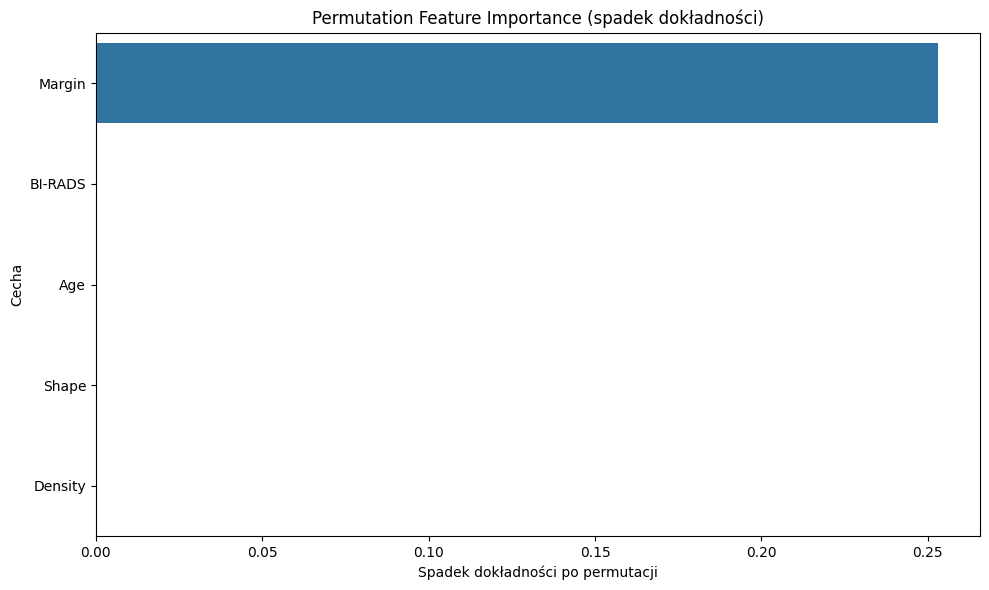

In [52]:
def compute_permutation_importance(model, dataloader, feature_names):
    model.eval()
    base_preds = []
    base_labels = []

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            logits = model(x_batch)
            probs = torch.sigmoid(logits)
            preds_class = (probs > 0.5).long().squeeze()
            base_preds.append(preds_class.cpu().numpy())
            base_labels.append(y_batch.cpu().numpy())

    base_preds = np.concatenate(base_preds)
    base_labels = np.concatenate(base_labels)
    base_acc = accuracy_score(base_labels, base_preds)

    importances = []

    for feature_idx, name in enumerate(feature_names):
        shuffled_preds = []

        with torch.no_grad():
            for x_batch, y_batch in dataloader:
                x_shuffled = x_batch.clone()
                shuffled_column = x_shuffled[:, feature_idx].cpu().numpy()
                np.random.shuffle(shuffled_column)
                x_shuffled[:, feature_idx] = torch.tensor(shuffled_column).to(x_batch.device)

                logits = model(x_shuffled)
                probs = torch.sigmoid(logits)
                preds_class = (probs > 0.5).long().squeeze()
                shuffled_preds.append(preds_class.cpu().numpy())

        shuffled_preds = np.concatenate(shuffled_preds)
        acc_after_shuffle = accuracy_score(base_labels, shuffled_preds)
        importance = base_acc - acc_after_shuffle
        importances.append((name, importance))

    return sorted(importances, key=lambda x: x[1], reverse=True)

importances = compute_permutation_importance(model, test_dataloader, feature_names)

for name, imp in importances:
    print(f"{name}: wpływ na dokładność = {imp:.4f}")

# Wykres
df_imp = pd.DataFrame(importances, columns=["Feature", "Importance"])
plt.figure(figsize=(10, 6))
sns.barplot(data=df_imp, x="Importance", y="Feature", color='C0')
plt.title("Permutation Feature Importance (spadek dokładności)")
plt.xlabel("Spadek dokładności po permutacji")
plt.ylabel("Cecha")
plt.tight_layout()
plt.show()


Model UTA-ANN przewiduje prawdopodobieństwo wystąpienia złośliwego guza piersi (klasa 1) na podstawie wartości cech diagnostycznych. W celu interpretacji zastosowano technikę Permutation Feature Importance.

Analiza wykazała, że spośród wszystkich cech jedynie Margin ma istotny wpływ na decyzje modelu — przetasowanie tej cechy powoduje wyraźny spadek dokładności klasyfikacji. Pozostałe cechy mają znikomy lub zerowy wpływ, co oznacza, że model praktycznie ignoruje je przy podejmowaniu decyzji.

Wszystkie cechy są monotoniczne, zgodnie z założeniami architektury UTA. Tylko cecha Margin działa jak cecha typu zysk — jej wyższa wartość zwiększa prawdopodobieństwo klasyfikacji jako złośliwy guz. Nie zaobserwowano progów preferencji ani obszarów nierozróżnialności — wpływ cech (dla Margin) zmienia się płynnie.

Wyniki uzyskane z techniki permutacji są spójne z analizą modelu — potwierdzają, że Margin jest jedyną decydującą cechą w podejmowaniu decyzji przez model.